In [366]:
# import required dependencies
import os
import random

import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from tqdm.notebook import tqdm_notebook

%matplotlib inline

# system device in use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# path to image directory
train_path = "/kaggle/input/fruits-classification/Fruits Classification/train"
test_path = "/kaggle/input/fruits-classification/Fruits Classification/test"
valid_path = "/kaggle/input/fruits-classification/Fruits Classification/valid"

In [319]:
class_names = ["Apple", "Banana", "Grape", "Mango", "Strawberry"]

test_image_list = []
for folder in os.listdir(test_path):
    folder_path = test_path+"/"+folder
    class_index = class_names.index(folder)
    for image_name in os.listdir(folder_path):
        image_path = folder_path+"/"+image_name
        test_image_list.append((image_path, class_index))
random.shuffle(test_image_list)

train_image_list = []
for folder in os.listdir(train_path):
    folder_path = train_path+"/"+folder
    class_index = class_names.index(folder)
    for image_name in os.listdir(folder_path):
        image_path = folder_path+"/"+image_name
        train_image_list.append((image_path, class_index))
random.shuffle(train_image_list)


valid_image_list = []
for folder in os.listdir(valid_path):
    folder_path = valid_path+"/"+folder
    class_index = class_names.index(folder)
    for image_name in os.listdir(folder_path):
        image_path = folder_path+"/"+image_name
        valid_image_list.append((image_path, class_index))
random.shuffle(valid_image_list)

In [320]:
print(f"Total train image: {len(train_image_list)}")
print(f"Total validation image: {len(valid_image_list)}")
print(f"Total test image: {len(test_image_list)}")

Total train image: 9700
Total validation image: 200
Total test image: 100


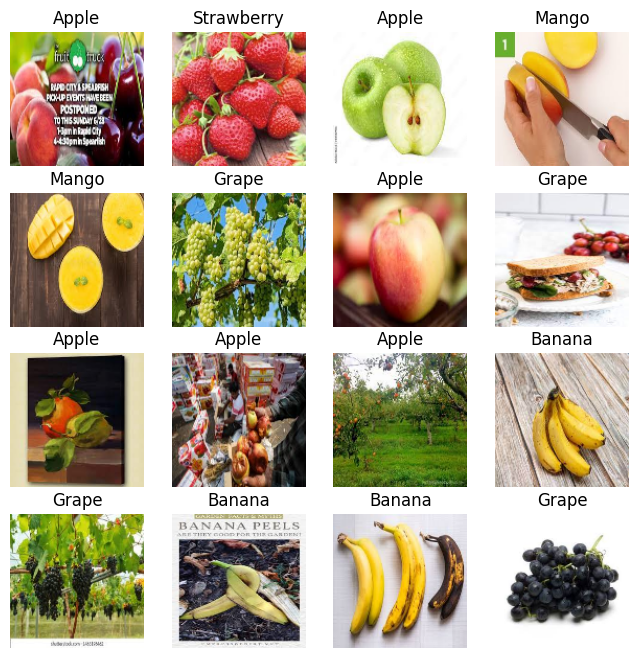

In [322]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

num_row = num_col = 4 

image_list = train_image_list.copy()
random.shuffle(image_list)
random_img_data = image_list[:num_row*num_row]

fig_size = 8
plt.figure(figsize=(fig_size, fig_size))

for position, image_data in enumerate(random_img_data):
    img = cv2.imread(image_data[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))

    plt.subplot(num_row, num_col, position+1)
    plt.imshow(img)
    plt.title(class_names[image_data[1]])
    plt.axis("off")

plt.show()

In [323]:
class ImageGen(torch.utils.data.Dataset):
    def __init__(self, image_list,
                 batch_size = 32,
                 image_height = 64,
                 image_width =64):
    
        self.image_list = image_list
        self.batch_size = batch_size
        self.IMAGE_HEIGHT = image_height
        self.IMAGE_WIDTH = image_width

        # calculate data length
        self.data_len = len(image_list)

    def __len__(self):
        return np.ceil(self.data_len / self.batch_size).astype("int")
    
    def data_length(self):
        return len(self.image_list)

    def __getitem__(self, index):
        from_index = index * self.batch_size
        to_index = (index + 1) * self.batch_size
        # add condition of last batch to_index
        if to_index > (self.data_len):
            to_index = self.data_len

        # take data of batch size
        batch_image_data = self.image_list[from_index:to_index]

        batch_main_images = []
        batch_labels = []

        for image_data in batch_image_data:
            img = cv2.imread(image_data[0]).astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            img = np.swapaxes(img,2,0)
            image_class = image_data[1]

            batch_main_images.append(img/255.)
            batch_labels.append(image_class)

        batch_main_images = np.array(batch_main_images)
        batch_labels = np.array(batch_labels)
        
        # convert to torch tensor
        batch_main_images = torch.from_numpy(batch_main_images)
        batch_labels = torch.from_numpy(batch_labels)

        return batch_main_images, batch_labels

In [358]:
# defining CNN blocks
class CNN_BLOCKS(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(num_features=out_channel)
        
    def forward(self, x_in):
        x = self.relu(self.conv1(x_in))
        x = self.batch_norm(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        return x

# defining the model
class Model(nn.Module):
    def __init__(self, in_channel=3, num_classes=5):
        super().__init__()
        self.cnn_block_1 = CNN_BLOCKS(in_channel = 3, out_channel = 64)
        self.cnn_block_2 = CNN_BLOCKS(in_channel = 64, out_channel = 128)
        self.cnn_block_3 = CNN_BLOCKS(in_channel = 128, out_channel = 256)
        
        self.fc1 = nn.Linear(256*8*8, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.relu = nn.ReLU()
  
    def forward(self, x):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.cnn_block_3(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [326]:
def train(model, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs):
    dataloader_train = DataLoader(dataloader_train, batch_size = 1, shuffle = True, num_workers = 0)

    loss_list = []
    acc_list = []
    val_acc_list = []
    for epoch in tqdm_notebook(range(num_epochs)):
        running_loss = 0
        accuracy = 0
        total_data = 0
        for batch_idx, data in enumerate(dataloader_train):
            images = data[0][0]
            labels = data[1][0].type(torch.int64)
            total_data += images.shape[0]
            # load data to device
            images = images.to(device=device)
            labels = labels.to(device=device)
            
            # forward pass
            pred = model(images)
            loss = criterion(pred, labels)
            # backward
            loss.backward()
            # gradient descent
            optimizer.step()
            optimizer.zero_grad()
            
            accuracy += (torch.argmax(pred, 1) == labels).sum().item()
            running_loss += loss.item() 
            
#         epoch_loss = running_loss / total_data
        loss_list.append(running_loss)
        acc_list.append(accuracy/total_data)
        
        valid_accuracy = cal_accuracy(model, dataloader_valid)
        val_acc_list.append(valid_accuracy)
        
        print(f"Epoch{epoch + 1:3}   Loss: {round(running_loss, 2):4}\t\tAvg. Train Acc.: {round(accuracy/total_data*100, 2):6}% \tAvg. Validation Acc.: {round(valid_accuracy*100, 3)}%")
        
    return loss_list, acc_list, val_acc_list

In [327]:
def cal_accuracy(model, loader):
    dataloader = DataLoader(loader, batch_size = 1, shuffle = True, num_workers = 0)
    
    model.eval()
    accuracy = 0
    total_data = 0
    
    for batch_idx, data in enumerate(dataloader):
        images = data[0][0]
        labels = data[1][0].type(torch.int64)
        total_data += images.shape[0]
        # load data to device
        images = images.to(device=device)
        labels = labels.to(device=device)

        # forward pass
        pred = model(images)

        accuracy += (torch.argmax(pred, 1) == labels).sum().item()

    return round(accuracy/total_data, 3)

In [396]:
def plot_cm(model, loader, class_names):
    dataloader = DataLoader(loader, batch_size = 1, shuffle = True, num_workers = 0)
    
    model.eval()
    y_pred = np.array([])
    y_truth = np.array([])
    
    for batch_idx, data in enumerate(dataloader):
        images = data[0][0]
        labels = data[1][0].numpy()
        
        # load data to device
        images = images.to(device=device)

        # forward pass
        pred = model(images)
        pred = torch.argmax(pred, 1).detach().cpu().numpy()
        
        y_pred = np.concatenate([y_pred, pred])
        y_truth = np.concatenate([y_truth, labels]) 
        
    cm = confusion_matrix(y_truth, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_truth, y_pred)
    sns.heatmap(cm, annot=True, xticklabels = class_names, yticklabels = class_names, cmap='Blues')
    
    print("______Precision_________ ")
    for clss, prec in zip(class_names, precision):
        print(f"\t{clss:10}_{round(prec*100, 2)}% ")
        
    print("\n______Recall_________ ")
    for clss, reca in zip(class_names, recall):
        print(f"\t{clss:10}_{round(reca*100, 2)}% ")
        
    print("\n_______F1score_________ ")
    for clss, f1 in zip(class_names, f1_score):
        print(f"\t{clss:10}_{round(f1*100, 2)}% ")

In [398]:
def pred_randm(model, loader):
    dataloader = DataLoader(loader, batch_size = 1, shuffle = True, num_workers = 0)
    
    model.eval()
    accuracy = 0
    total_data = 0
    
    for batch_idx, data in enumerate(dataloader):
        images = data[0][0][:16]
        print(images.shape)
        labels = data[1][0][:16].type(torch.int64)
        total_data += images.shape[0]
        # load data to device
        images = images.to(device=device)
        labels = labels.to(device=device)

        # forward pass
        pred = model(images)
        pred = torch.argmax(pred, 1).detach().cpu().numpy()
        break
        
    num_row = num_col = 4 # assume squared grid
    
    fig_size = 15
    plt.figure(figsize=(fig_size, fig_size))
    
    images = images.detach().cpu().numpy()
    images = np.swapaxes(images,1,3)

    for position, image_data in enumerate(images):

        # Plot the image
        plt.subplot(num_row, num_col, position+1)
        plt.imshow(image_data)
        plt.title(f"Original cls {class_names[labels[position]]}\nPredicted cls {class_names[pred[position]]}")
        plt.axis("off")

    plt.show()

In [355]:
BATCH_SIZE = 256
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
NUM_EPOCHS = 20
train_loader = ImageGen(train_image_list, batch_size = BATCH_SIZE, image_height = IMAGE_HEIGHT, image_width =IMAGE_WIDTH)
test_loader = ImageGen(test_image_list, batch_size = BATCH_SIZE, image_height = IMAGE_HEIGHT, image_width =IMAGE_WIDTH)
valid_loader = ImageGen(valid_image_list, batch_size = BATCH_SIZE, image_height = IMAGE_HEIGHT, image_width =IMAGE_WIDTH)

In [359]:
model = Model().to(device)

criterion = nn.CrossEntropyLoss()
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [360]:
epoch_loss, accuracy, val_acc = train(model = model, dataloader_train = train_loader, dataloader_valid = valid_loader, 
      criterion = criterion, optimizer = optimizer, num_epochs = NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch  1   Loss: 81.537	Avg. Train Acc.:  35.08% 	Avg. Validation Acc.: 36.5%
Epoch  2   Loss: 44.149	Avg. Train Acc.:  50.03% 	Avg. Validation Acc.: 53.0%
Epoch  3   Loss: 40.29	Avg. Train Acc.:   55.0% 	Avg. Validation Acc.: 53.5%
Epoch  4   Loss: 38.744	Avg. Train Acc.:  57.55% 	Avg. Validation Acc.: 57.0%
Epoch  5   Loss: 35.861	Avg. Train Acc.:  61.16% 	Avg. Validation Acc.: 55.0%
Epoch  6   Loss: 35.208	Avg. Train Acc.:  62.11% 	Avg. Validation Acc.: 59.5%
Epoch  7   Loss: 33.023	Avg. Train Acc.:  65.66% 	Avg. Validation Acc.: 57.0%
Epoch  8   Loss: 31.752	Avg. Train Acc.:  67.47% 	Avg. Validation Acc.: 64.5%
Epoch  9   Loss: 30.712	Avg. Train Acc.:  67.89% 	Avg. Validation Acc.: 64.5%
Epoch 10   Loss: 28.075	Avg. Train Acc.:  71.32% 	Avg. Validation Acc.: 62.0%
Epoch 11   Loss: 26.327	Avg. Train Acc.:  73.43% 	Avg. Validation Acc.: 65.5%
Epoch 12   Loss: 24.863	Avg. Train Acc.:   75.2% 	Avg. Validation Acc.: 66.5%
Epoch 13   Loss: 22.765	Avg. Train Acc.:  77.15% 	Avg. Validation

In [363]:
test_accuracy = cal_accuracy(model, test_loader)
print(f"Test accuracy: {round(test_accuracy*100, 3)}%")

Test accuracy: 70.0%


______Precision_________ 
	Apple     _66.67% 
	Banana    _53.57% 
	Grape     _82.35% 
	Mango     _66.67% 
	Strawberry_93.75% 

______Recall_________ 
	Apple     _70.0% 
	Banana    _75.0% 
	Grape     _70.0% 
	Mango     _60.0% 
	Strawberry_75.0% 

_______F1score_________ 
	Apple     _68.29% 
	Banana    _62.5% 
	Grape     _75.68% 
	Mango     _63.16% 
	Strawberry_83.33% 


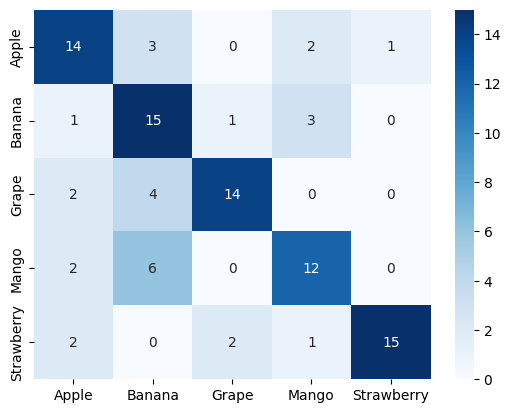

In [397]:
plot_cm(model, test_loader, class_names)

torch.Size([16, 3, 64, 64])


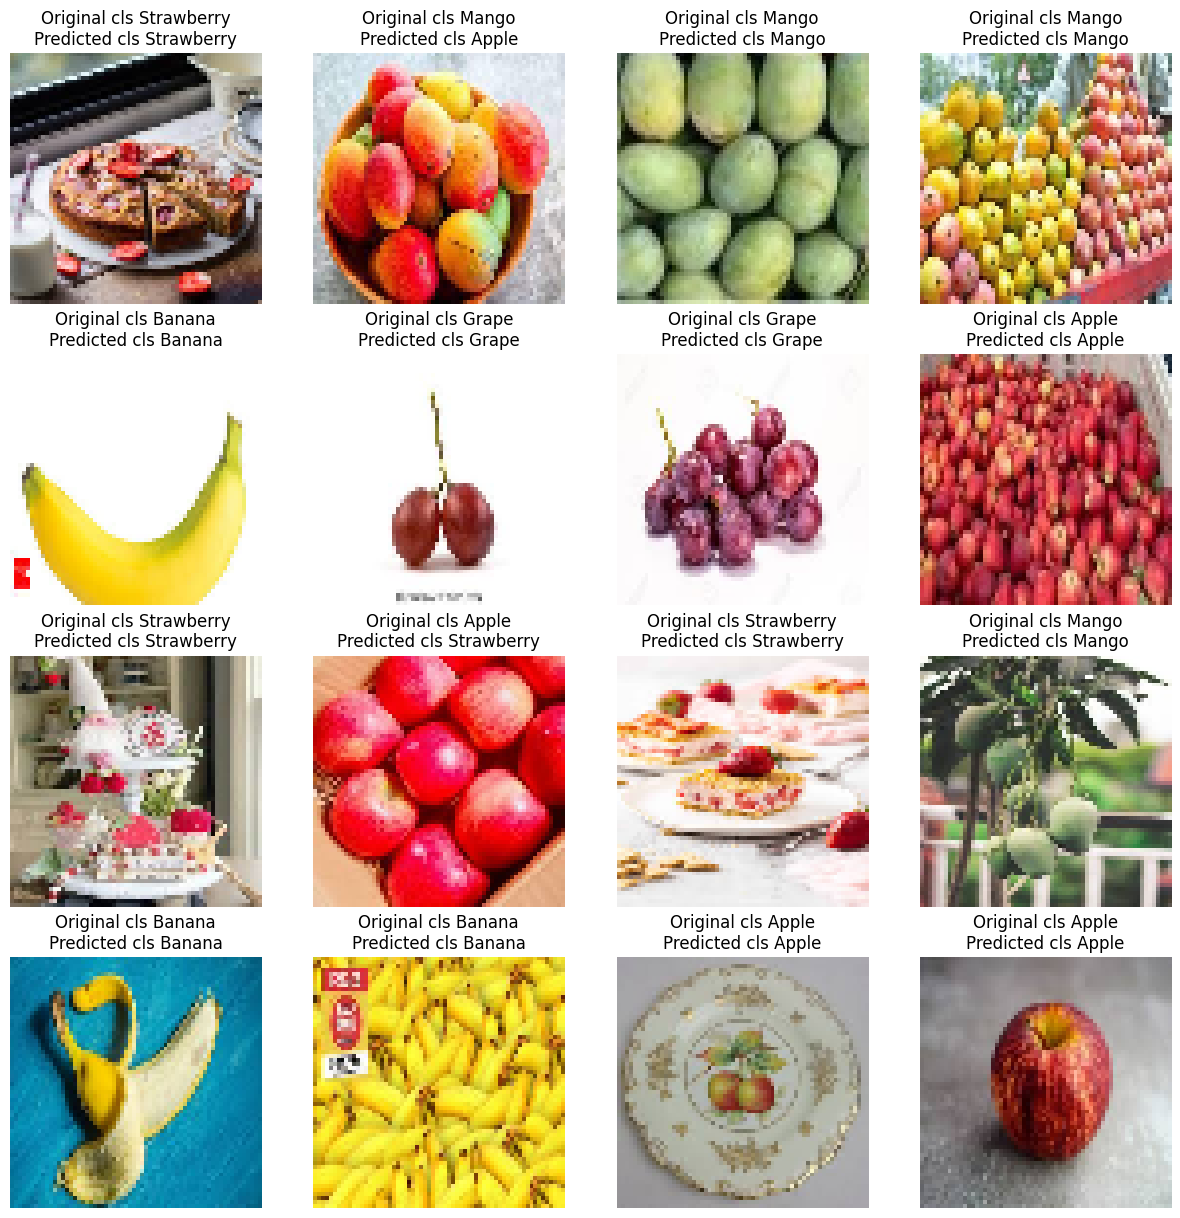

In [399]:
pred_randm(model, test_loader)